In [1]:
# load the files
import glob
import numpy as np
import pandas as pd

from PIL import Image

X_train_path = "./training/*"
X_test_path = "./testing/*"

X_train = np.zeros(shape=(1500, 101, 101, 3))
for img_path in glob.glob(X_train_path):
    image_index = int(img_path.split("/")[-1].split(".")[0])
    im = Image.open(img_path)
    X_train[image_index] = np.array(im)
    pass

X_test = np.zeros(shape=(558, 101, 101, 3))
for img_path in glob.glob(X_test_path):
    image_index = int(img_path.split("/")[-1].split(".")[0]) - 1500
    im = Image.open(img_path)
    X_test[image_index] = np.array(im)
    pass

Y_train = pd.read_csv("labels_training.csv")["label"].values

print("Y mean: {}".format(np.mean(Y_train)))

Y mean: 0.33666666666666667


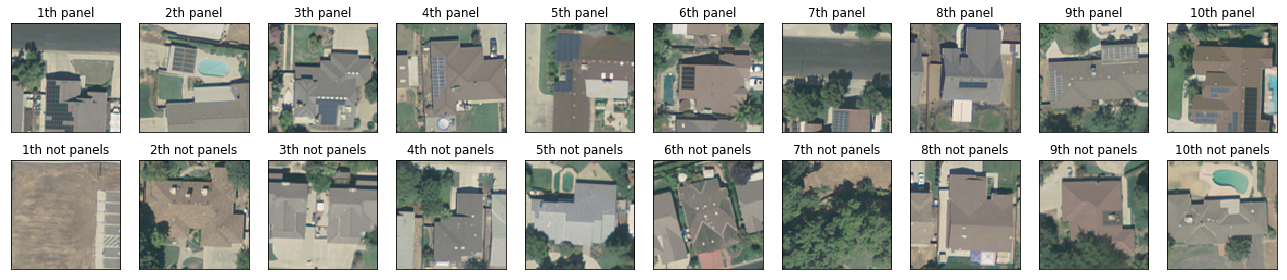

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
# visualization of raw data
plt.figure(figsize=(18, 4))
for i in range(10):
    x_tr1 = Image.fromarray(X_train[Y_train == 1][i].astype('uint8'))
    x_tr0 = Image.fromarray(X_train[Y_train == 0][i].astype('uint8'))
    plt.subplot(2, 10, i+1)
    plt.imshow(x_tr1, cmap="gray")
    plt.yticks([])
    plt.xticks([])
    plt.title("{}th panel".format(i + 1))
    plt.subplot(2, 10, i+11)
    plt.imshow(x_tr0, cmap="gray")
    plt.title("{}th not panels".format(i + 1))
    plt.yticks([])
    plt.xticks([])
plt.tight_layout()
plt.savefig("raw data")

In [3]:
plt.savefig("raw data")

<Figure size 432x288 with 0 Axes>

In [6]:
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Dropout
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import keras
from keras.models import Model
from keras.layers import Input
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# base model
model_conv_layers = keras.applications.xception.Xception(weights='imagenet', include_top=False).layers

Using TensorFlow backend.


In [193]:
a = model_conv_layers[1](inp)
a = model_conv_layers[2](a)
a = model_conv_layers[3](a)
a = model_conv_layers[4](a)
a = model_conv_layers[5](a)
a = model_conv_layers[6](a)
a = model_conv_layers[7](a)
a = model_conv_layers[8](a)
a = model_conv_layers[9](a)
a = model_conv_layers[10](a)
a = model_conv_layers[11](a)
print(a, model_conv_layers[12])
a = model_conv_layers[12](a)

Tensor("block2_sepconv2_bn_19/cond/Merge:0", shape=(?, 48, 48, 128), dtype=float32) <keras.layers.convolutional.Conv2D object at 0x1f27b4320>


ValueError: Input 0 is incompatible with layer conv2d_37: expected axis -1 of input shape to have value 64 but got shape (None, 48, 48, 128)

In [186]:
from sklearn.model_selection import train_test_split

# split data
trainX, testX, trainy, testy = train_test_split(X_train, Y_train, test_size=0.10, shuffle= True)

# evaluate model
#input
inp = Input(shape=(101,101, 3),name = 'image_input')

#Use the generated model 
i = 0
output_conv = model_conv_layers[1](inp)
for layer in model_conv_layers[2:]:
    output_conv = layer(output_conv)
    print(i); i+=1

#output
x = Flatten(name='flatten')(output_conv)
x = Dense(1, activation='sigmoid', name='predictions')(x)

my_model = Model(inputs=inp, output=x)
    
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=2, min_lr=0.1e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=5, restore_best_weights=True)

my_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
history = my_model.fit(trainX, trainy,
                  batch_size=32,
                  epochs=1,
                  verbose=1,
                  shuffle = True,
                  callbacks=[lr_reducer, early_stopper],
                  validation_data = (testX, testy))

0
1
2
3
4
5
6
7
8
9


ValueError: Input 0 is incompatible with layer conv2d_37: expected axis -1 of input shape to have value 64 but got shape (None, 48, 48, 128)

In [135]:
y_hat = my_model.predict(testX)
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc_score(testy.ravel(), y_hat.ravel())

0.9978559176672385

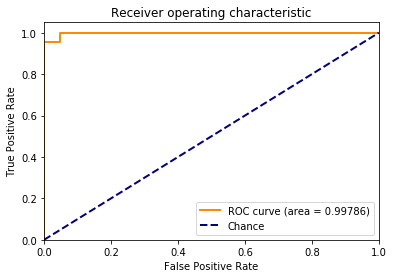

In [88]:
new_auc = roc_auc_score(testy, y_hat)

import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(testy, y_hat)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.5f)' % new_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('roc test')

In [19]:
# the best performance model

from keras.models import load_model

my_model = load_model("./model1.h5")

KeyboardInterrupt: 

In [17]:

y_hat_pretrain = my_model.predict(X_test)


import pandas as pd
answer = pd.DataFrame({"id": np.arange(1500, 1500+len(y_hat_pretrain)),
              "score": y_hat_pretrain.ravel()})
answer.to_csv("submission_pre.csv", index=False)

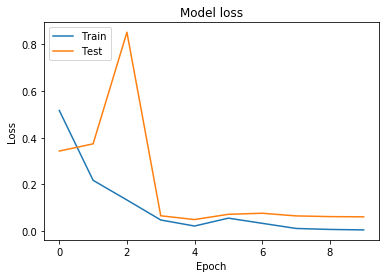

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.savefig("accurcy")

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("loss")

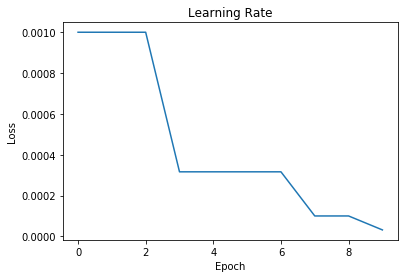

In [18]:
# Plot training & validation loss values
plt.plot(history.history['lr'])
plt.title('Learning Rate')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig("lr")

In [164]:
model = Model(my_model.input, my_model.layers[1].get_layer("block1_conv2").output)


ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_10:0", shape=(?, ?, ?, 3), dtype=float32) at layer "input_10". The following previous layers were accessed without issue: []

In [156]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [158]:
for layer in my_model.layers[1].layers:
    print(layer.name)

input_7
block1_conv1
block1_conv1_bn
block1_conv1_act
block1_conv2
block1_conv2_bn
block1_conv2_act
block2_sepconv1
block2_sepconv1_bn
block2_sepconv2_act
block2_sepconv2
block2_sepconv2_bn
conv2d_25
block2_pool
batch_normalization_25
add_73
block3_sepconv1_act
block3_sepconv1
block3_sepconv1_bn
block3_sepconv2_act
block3_sepconv2
block3_sepconv2_bn
conv2d_26
block3_pool
batch_normalization_26
add_74
block4_sepconv1_act
block4_sepconv1
block4_sepconv1_bn
block4_sepconv2_act
block4_sepconv2
block4_sepconv2_bn
conv2d_27
block4_pool
batch_normalization_27
add_75
block5_sepconv1_act
block5_sepconv1
block5_sepconv1_bn
block5_sepconv2_act
block5_sepconv2
block5_sepconv2_bn
block5_sepconv3_act
block5_sepconv3
block5_sepconv3_bn
add_76
block6_sepconv1_act
block6_sepconv1
block6_sepconv1_bn
block6_sepconv2_act
block6_sepconv2
block6_sepconv2_bn
block6_sepconv3_act
block6_sepconv3
block6_sepconv3_bn
add_77
block7_sepconv1_act
block7_sepconv1
block7_sepconv1_bn
block7_sepconv2_act
block7_sepconv2

In [165]:
model_conv_layers = keras.applications.xception.Xception(weights='imagenet', include_top=False).layers


In [175]:
model_conv_layers[1].name

'block1_conv1'

In [170]:
model_conv_layers[1](inp)

<tf.Tensor 'block1_conv1_12/convolution:0' shape=(?, 50, 50, 32) dtype=float32>